<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/ExtractFeaturesnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
classeses = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classeses.append(i)
classeses

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2023-11-28 22:09:02--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  15.7MB/s    in 6.1s    

2023-11-28 22:09:08 (10.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [4]:
import cv2
import dlib
import numpy as np
import os
from collections import Counter

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/gdrive/My Drive/ColabNotebooks/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

# Your existing code to load images
features_or = []
labels_or = []
train_data_or = []
failed_indices = []
def create_images():
    for i, photo in enumerate(classeses):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE to improve the contrast locally
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)

            # If no faces are detected with CLAHE, try standard histogram equalization
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(image_to_use, face)
                combined_region = extract_and_combine_regions(image_to_use, landmarks)

                # Append the combined image and its label to the list
                features_or.append(combined_region)  # Append the combined region
                labels_or.append(label)

                train_data_or.append([combined_region, label])
            else:
                failed_indices.append(i)

create_images()
# Print the label counts
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

Label 0: 419 images
Label 1: 448 images
Label 2: 372 images
Label 3: 610 images
Label 4: 142 images
Label 5: 896 images
Label 6: 585 images
Label 7: 292 images


In [5]:
for label, count in label_counts_or.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 neutrality: 419 images
Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 3 surprise: 610 images
Label 4 contempt: 142 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Label 7 disgust: 292 images


In [6]:
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [1, 5]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 1 sadness: 448 images
Label 5 happiness: 896 images
Filtered Features Shape: (1344, 224, 224)
Filtered Labels Shape: (1344,)


In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import cv2

def plot_first_n_images(images, labels, classes, n=5):
    num_unique_labels = len(np.unique(labels))  # Get the number of unique labels
    fig, axes = plt.subplots(num_unique_labels, n, figsize=(n*2, num_unique_labels*2))

    # Initialize a dictionary to store image indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Plot 'n' images for each unique label
    for label_idx, label in enumerate(np.unique(labels)):
        indices = label_indices[label][:n]  # Get the first 'n' indices for this label
        for img_idx, img_index in enumerate(indices):
            axes[label_idx, img_idx].imshow(images[img_index], cmap='gray')
            axes[label_idx, img_idx].set_title(f"Label: {classes[label]}")
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

# plot each emotion
#plot_first_n_images(features_or, labels_or, classeses, n=5)

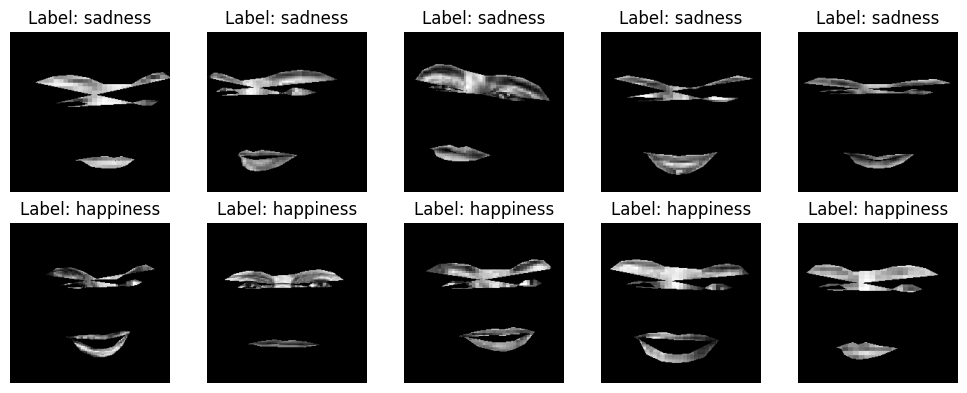

In [8]:
plot_first_n_images(features_filtered, labels_filtered, classeses, n=5)

In [71]:
labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 5] = 1
np.unique(labels_filtered)

array([0, 1])

In [13]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])

# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)



# split your datasets into training, validation, and test sets with a 60-20-20 percent ratio,
def split_dataset(dataset, train_percent=0.60, val_percent=0.20):
    total_size = len(dataset)
    train_size = int(total_size * train_percent)
    val_size = int(total_size * val_percent)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

In [75]:
# Prepare datasets for eyes, eyebrows, and mouth
combined_dataset = prepare_dataset(features_filtered, labels_filtered, transform)
# Split each dataset into training, validation, and test sets
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_dataset(combined_dataset)


# Create DataLoaders for training and validation for each region
Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CombinedCNN(nn.Module):
    def __init__(self, num_classes):
        super(CombinedCNN, self).__init__()

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        self.name = "CombinedCNN"
    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x



In [39]:
class CNNetResidual(nn.Module):
    def __init__(self, num_classes=10, num_in_channels=1):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, 64)
        )

        self.downconv2 = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=7, padding=1,stride = 2),  # Fix the number of input channels
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(128, 256)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(384 * 13 * 13, 1024),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

        self.name = "CNNetResidual"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)

        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First 1x1 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu1 = nn.ReLU()

        # Second 3x3 Convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out

In [69]:
random_input = torch.randn(1, 1, 224, 224)  # Assuming num_in_channels is 1
random_input2 = torch.randn(64,32, 55, 55)
# Instantiate the model
model = CNNetResidual(2)

# Pass the input through the model
output = model(random_input)
# Print the output tensor size
print("Output Tensor Size:", output.size())

Output Tensor Size: torch.Size([1, 2])


In [60]:
random_input2 = torch.randn(1, 32, 55, 55)
model2 = ResidualBlock(32, 32)
output2 = model2(random_input2)
print("Output2 Tensor Size:", output2.size())

Output2 Tensor Size: torch.Size([1, 64, 55, 55])


Train Region-Specific CNNs (RegionCNN):
Train the RegionCNN models separately for each facial region (eyes, eyebrows, mouth) using the corresponding part of the face images.


In [11]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return correct / total

In [11]:
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = '/content/gdrive/My Drive/ColabNotebooks/new'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch] = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")
        print(print(f"Saved model checkpoint: {model_path}"))

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

In [ ]:
use_cuda = True
num_classes = 8
combined_model = CombinedCNN(num_classes)
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.01, num_epochs=60)


In [73]:
use_cuda = True
num_classes = 2
combined_model = CNNetResidual(2)
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=60)

Training Begin...

Epoch 1: Train Acc: 0.70, Train Loss: 0.9906 | Val Acc: 0.76, Val Loss: 0.6234
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr0.0001_epoch0
None
Epoch 2: Train Acc: 0.77, Train Loss: 0.5111 | Val Acc: 0.77, Val Loss: 0.4229
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr0.0001_epoch1
None
Epoch 3: Train Acc: 0.76, Train Loss: 0.4337 | Val Acc: 0.76, Val Loss: 0.4413
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr0.0001_epoch2
None
Epoch 4: Train Acc: 0.86, Train Loss: 0.4054 | Val Acc: 0.81, Val Loss: 0.3439
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr0.0001_epoch3
None
Epoch 5: Train Acc: 0.87, Train Loss: 0.3485 | Val Acc: 0.79, Val Loss: 0.3522
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr0.0001_epoch4
None
Epoch 6: Train A

KeyboardInterrupt: ignored

Training Begin...

Epoch 1: Train Acc: 0.73, Train Loss: 0.6196 | Val Acc: 0.74, Val Loss: 0.6487
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr1e-05_epoch0
None
Epoch 2: Train Acc: 0.82, Train Loss: 0.4734 | Val Acc: 0.75, Val Loss: 0.5185
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr1e-05_epoch1
None
Epoch 3: Train Acc: 0.84, Train Loss: 0.4252 | Val Acc: 0.79, Val Loss: 0.3886
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr1e-05_epoch2
None
Epoch 4: Train Acc: 0.85, Train Loss: 0.3846 | Val Acc: 0.79, Val Loss: 0.3752
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr1e-05_epoch3
None
Epoch 5: Train Acc: 0.87, Train Loss: 0.3400 | Val Acc: 0.79, Val Loss: 0.3647
Saved model checkpoint: /content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr1e-05_epoch4
None
Epoch 6: Train Acc: 0

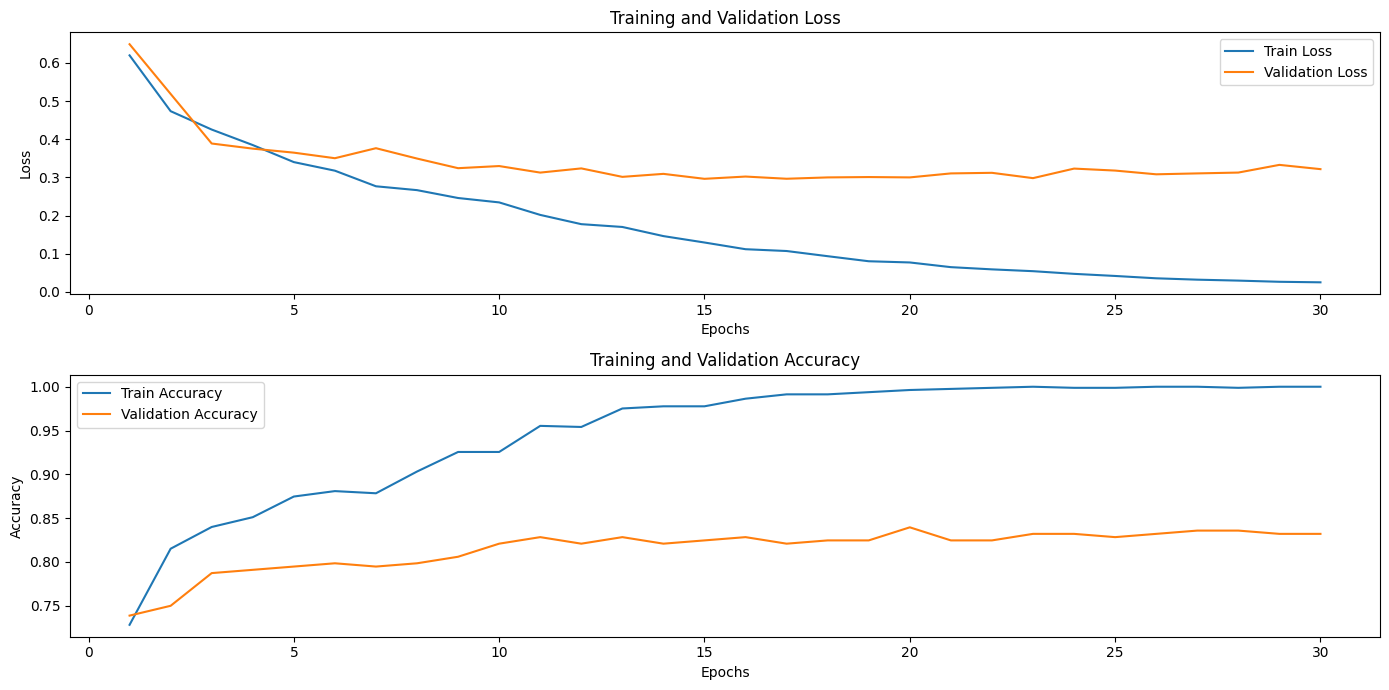

In [85]:
num_classes = 2
combined_model2 = CNNetResidual(2)
Model1 = trainmodel(combined_model2, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=30)

In [86]:
best_model = CNNetResidual(2)
best_model.load_state_dict(torch.load('/content/gdrive/My Drive/ColabNotebooks/new/model_CNNetResidual_bs64_lr1e-05_epoch19.pt'))


<All keys matched successfully>

In [87]:
print("Test Acc %f;" % (evaluate(best_model, combined_test_dataset)))

ValueError: ignored

In [20]:
def trainmodelnotsave(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch] = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")


    print("Finished Training")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

In [14]:
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [1, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 1 sadness: 448 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Filtered Features Shape: (1929, 224, 224)
Filtered Labels Shape: (1929,)


In [89]:
labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 5] = 1
labels_filtered[labels_filtered == 6] = 2
np.unique(labels_filtered)

array([0, 1, 2])

In [90]:
# Split each dataset into training, validation, and test sets
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_dataset(combined_dataset)
# Create DataLoaders for training and validation for each region
Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

Training Begin...

Epoch 1: Train Acc: 0.67, Train Loss: 0.8083 | Val Acc: 0.65, Val Loss: 0.6491
Epoch 2: Train Acc: 0.67, Train Loss: 0.6368 | Val Acc: 0.65, Val Loss: 0.6683
Epoch 3: Train Acc: 0.67, Train Loss: 0.6263 | Val Acc: 0.65, Val Loss: 0.6287
Epoch 4: Train Acc: 0.74, Train Loss: 0.5885 | Val Acc: 0.69, Val Loss: 0.6001
Epoch 5: Train Acc: 0.74, Train Loss: 0.5224 | Val Acc: 0.71, Val Loss: 0.5882
Epoch 6: Train Acc: 0.80, Train Loss: 0.4431 | Val Acc: 0.73, Val Loss: 0.5406
Epoch 7: Train Acc: 0.80, Train Loss: 0.4142 | Val Acc: 0.74, Val Loss: 0.5054
Epoch 8: Train Acc: 0.82, Train Loss: 0.4110 | Val Acc: 0.74, Val Loss: 0.4994
Epoch 9: Train Acc: 0.82, Train Loss: 0.3966 | Val Acc: 0.74, Val Loss: 0.4910
Epoch 10: Train Acc: 0.82, Train Loss: 0.3711 | Val Acc: 0.75, Val Loss: 0.4863
Epoch 11: Train Acc: 0.82, Train Loss: 0.3600 | Val Acc: 0.75, Val Loss: 0.4752
Epoch 12: Train Acc: 0.83, Train Loss: 0.3577 | Val Acc: 0.76, Val Loss: 0.4718
Epoch 13: Train Acc: 0.85, Tra

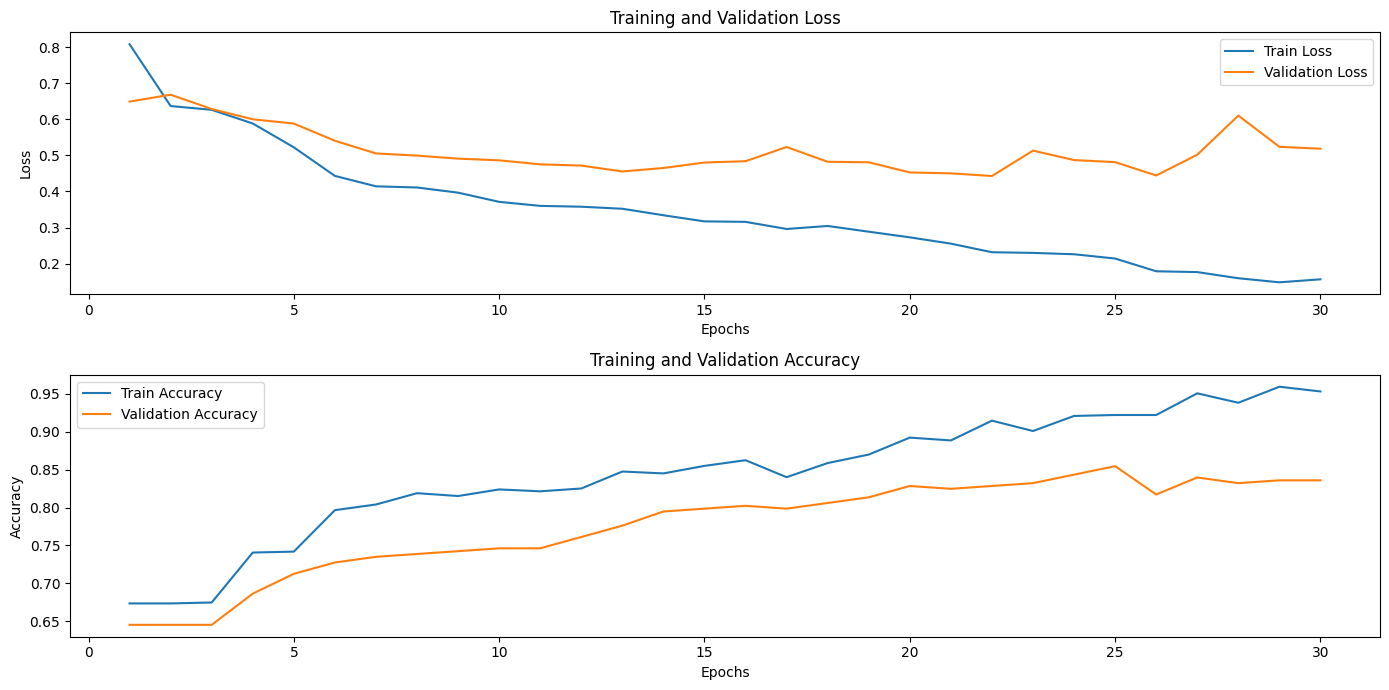

In [92]:
combined_model = CombinedCNN(3)
Model1 = trainmodelnotsave(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0001, num_epochs=30)

In [15]:
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [1, 2, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Filtered Features Shape: (2301, 224, 224)
Filtered Labels Shape: (2301,)


In [16]:
labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 1] = 0
labels_filtered[labels_filtered == 2] = 1
labels_filtered[labels_filtered == 5] = 2
labels_filtered[labels_filtered == 6] = 3
np.unique(labels_filtered)

array([0, 1, 2, 3])

In [17]:
# Split each dataset into training, validation, and test sets
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_dataset(combined_dataset)
# Create DataLoaders for training and validation for each region
Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

Training Begin...

Epoch 1: Train Acc: 0.67, Train Loss: 0.8542 | Val Acc: 0.64, Val Loss: 0.6750
Epoch 2: Train Acc: 0.68, Train Loss: 0.6534 | Val Acc: 0.64, Val Loss: 0.6748
Epoch 3: Train Acc: 0.68, Train Loss: 0.6316 | Val Acc: 0.64, Val Loss: 0.6901
Epoch 4: Train Acc: 0.68, Train Loss: 0.6333 | Val Acc: 0.64, Val Loss: 0.6683
Epoch 5: Train Acc: 0.68, Train Loss: 0.6381 | Val Acc: 0.64, Val Loss: 0.6666
Epoch 6: Train Acc: 0.68, Train Loss: 0.6453 | Val Acc: 0.64, Val Loss: 0.6692
Epoch 7: Train Acc: 0.68, Train Loss: 0.6327 | Val Acc: 0.64, Val Loss: 0.6791
Epoch 8: Train Acc: 0.68, Train Loss: 0.6363 | Val Acc: 0.64, Val Loss: 0.6698
Epoch 9: Train Acc: 0.68, Train Loss: 0.6337 | Val Acc: 0.64, Val Loss: 0.6776
Epoch 10: Train Acc: 0.68, Train Loss: 0.6385 | Val Acc: 0.64, Val Loss: 0.6692
Epoch 11: Train Acc: 0.68, Train Loss: 0.6392 | Val Acc: 0.64, Val Loss: 0.6850
Epoch 12: Train Acc: 0.68, Train Loss: 0.6332 | Val Acc: 0.64, Val Loss: 0.6664
Epoch 13: Train Acc: 0.68, Tra

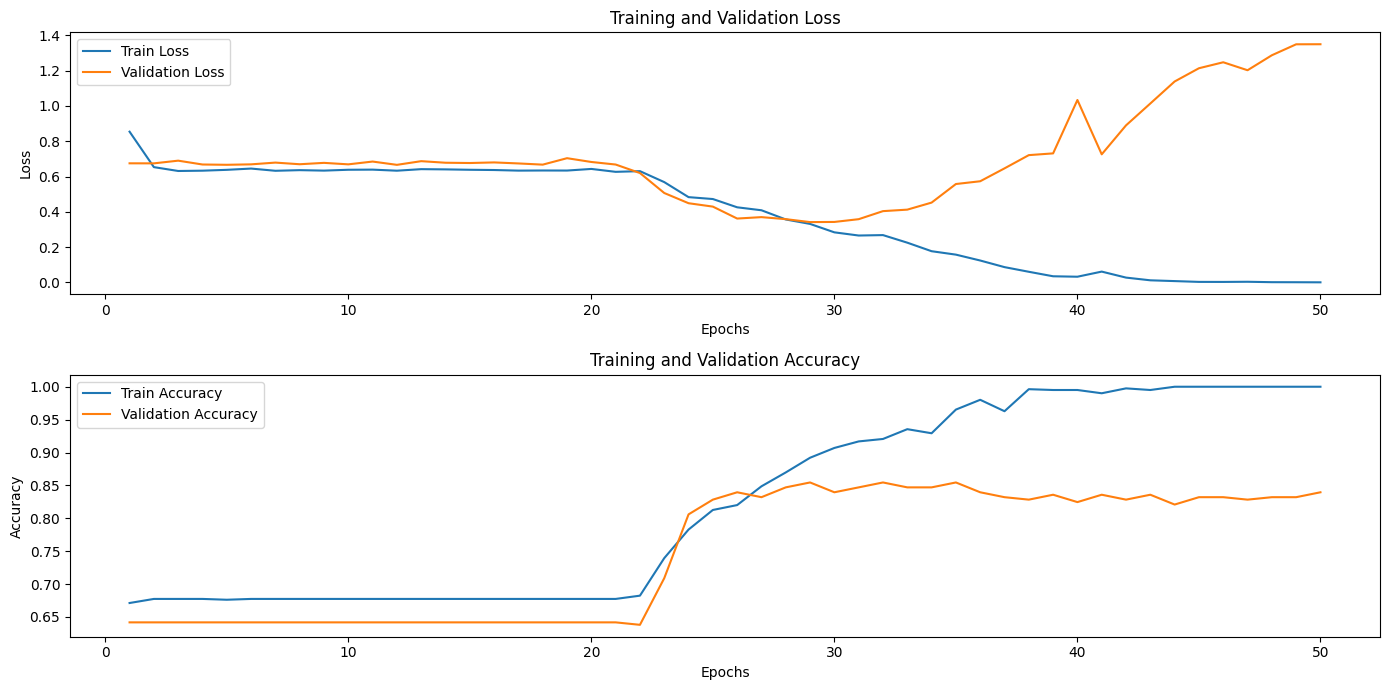

In [99]:
combined_model = CombinedCNN(4)
Model1 = trainmodelnotsave(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.001, num_epochs=50)

In [ ]:
trainmodel
combined_model = CombinedCNN(4)
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.001, num_epochs=40)

In [44]:
class CNNetResidual2(nn.Module):
    def __init__(self, num_classes=10, num_in_channels=1):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, 64)
        )
        self.downconv2 = nn.Sequential(
            nn.Conv2d(96, 120, kernel_size=8, padding=1),  # Fix the number of input channels
            nn.BatchNorm2d(120),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.downconv3 = nn.Sequential(
            nn.Conv2d(120, 164, kernel_size=7, padding=1),  # Fix the number of input channels
            nn.BatchNorm2d(164),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(164, 32)
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(196 * 10 * 10, 1024),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.Linear(256, num_classes)
        )

        self.name = "CNNetResidual"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.downconv3(out)
        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First 1x1 Convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu1 = nn.ReLU()

        # Second 3x3 Convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out

Training Begin...

Epoch 1: Train Acc: 0.51, Train Loss: 1.2337 | Val Acc: 0.29, Val Loss: 1.2918
Epoch 2: Train Acc: 0.57, Train Loss: 1.0794 | Val Acc: 0.50, Val Loss: 1.1677
Epoch 3: Train Acc: 0.61, Train Loss: 1.0161 | Val Acc: 0.58, Val Loss: 1.1135
Epoch 4: Train Acc: 0.59, Train Loss: 0.9558 | Val Acc: 0.56, Val Loss: 1.0917
Epoch 5: Train Acc: 0.65, Train Loss: 0.9213 | Val Acc: 0.58, Val Loss: 1.0830
Epoch 6: Train Acc: 0.67, Train Loss: 0.8899 | Val Acc: 0.59, Val Loss: 1.0466
Epoch 7: Train Acc: 0.69, Train Loss: 0.8664 | Val Acc: 0.60, Val Loss: 1.0423
Epoch 8: Train Acc: 0.66, Train Loss: 0.8142 | Val Acc: 0.59, Val Loss: 1.0233
Epoch 9: Train Acc: 0.71, Train Loss: 0.8052 | Val Acc: 0.62, Val Loss: 1.0148
Epoch 10: Train Acc: 0.72, Train Loss: 0.7754 | Val Acc: 0.60, Val Loss: 1.0022
Epoch 11: Train Acc: 0.69, Train Loss: 0.7383 | Val Acc: 0.59, Val Loss: 1.0274
Epoch 12: Train Acc: 0.75, Train Loss: 0.7523 | Val Acc: 0.62, Val Loss: 0.9807
Epoch 13: Train Acc: 0.76, Tra

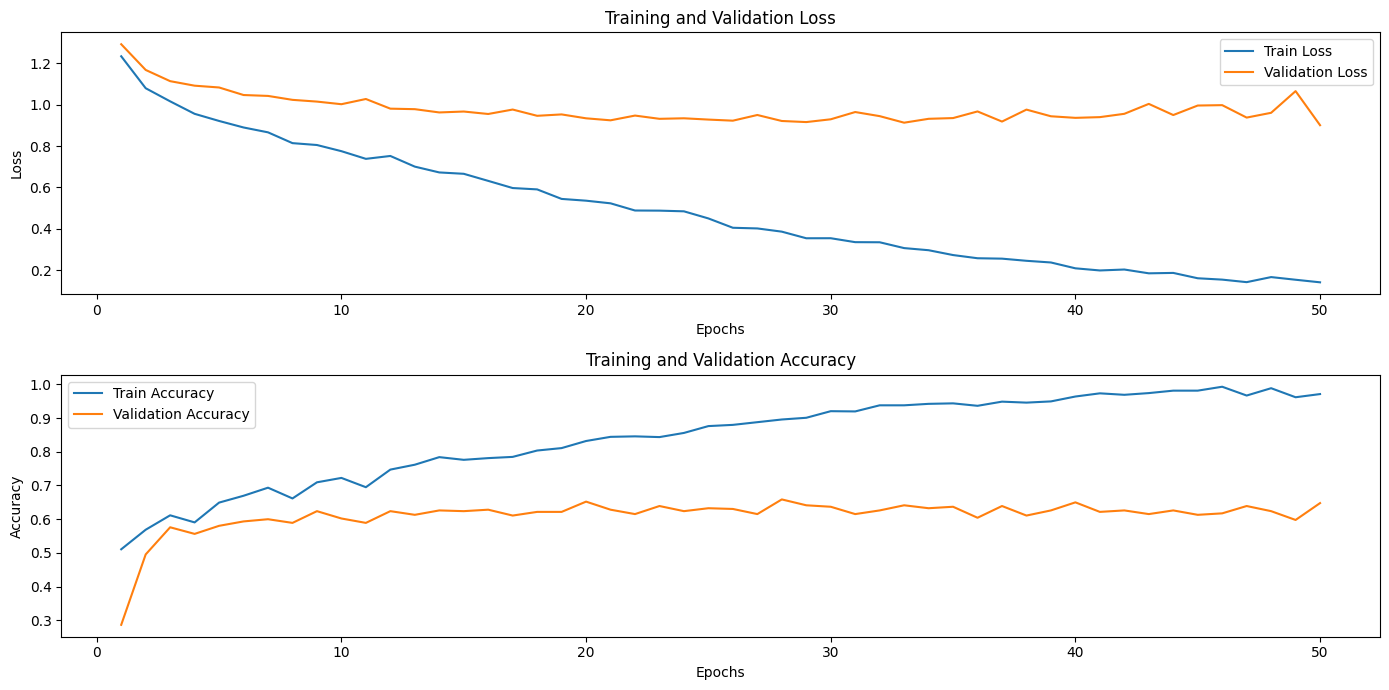

In [35]:
use_cuda = True
combined_model2 = CNNetResidual2(4)
Model1 = trainmodelnotsave(combined_model2, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=50)

In [36]:
# include 6 class(do not include disgust and contempt)
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [0, 1, 2, 3, 5, 6]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 0 neutrality: 419 images
Label 1 sadness: 448 images
Label 2 fear: 372 images
Label 3 surprise: 610 images
Label 5 happiness: 896 images
Label 6 anger: 585 images
Filtered Features Shape: (3330, 224, 224)
Filtered Labels Shape: (3330,)


In [37]:
labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 0] = 0
labels_filtered[labels_filtered == 1] = 1
labels_filtered[labels_filtered == 2] = 2
labels_filtered[labels_filtered == 3] = 3
labels_filtered[labels_filtered == 5] = 4
labels_filtered[labels_filtered == 6] = 5
np.unique(labels_filtered)

array([0, 1, 2, 3, 4, 5])

Training Begin...

Epoch 1: Train Acc: 0.48, Train Loss: 1.3106 | Val Acc: 0.35, Val Loss: 1.3648
Epoch 2: Train Acc: 0.56, Train Loss: 1.1075 | Val Acc: 0.53, Val Loss: 1.1843
Epoch 3: Train Acc: 0.58, Train Loss: 1.0381 | Val Acc: 0.52, Val Loss: 1.1622
Epoch 4: Train Acc: 0.63, Train Loss: 0.9898 | Val Acc: 0.56, Val Loss: 1.1229
Epoch 5: Train Acc: 0.64, Train Loss: 0.9288 | Val Acc: 0.57, Val Loss: 1.0971
Epoch 6: Train Acc: 0.66, Train Loss: 0.8872 | Val Acc: 0.58, Val Loss: 1.0830
Epoch 7: Train Acc: 0.66, Train Loss: 0.8686 | Val Acc: 0.58, Val Loss: 1.0687
Epoch 8: Train Acc: 0.69, Train Loss: 0.8339 | Val Acc: 0.61, Val Loss: 1.0420
Epoch 9: Train Acc: 0.69, Train Loss: 0.8031 | Val Acc: 0.61, Val Loss: 1.0286
Epoch 10: Train Acc: 0.72, Train Loss: 0.8039 | Val Acc: 0.61, Val Loss: 1.0381
Epoch 11: Train Acc: 0.72, Train Loss: 0.7500 | Val Acc: 0.61, Val Loss: 1.0251
Epoch 12: Train Acc: 0.73, Train Loss: 0.7448 | Val Acc: 0.61, Val Loss: 1.0196
Epoch 13: Train Acc: 0.75, Tra

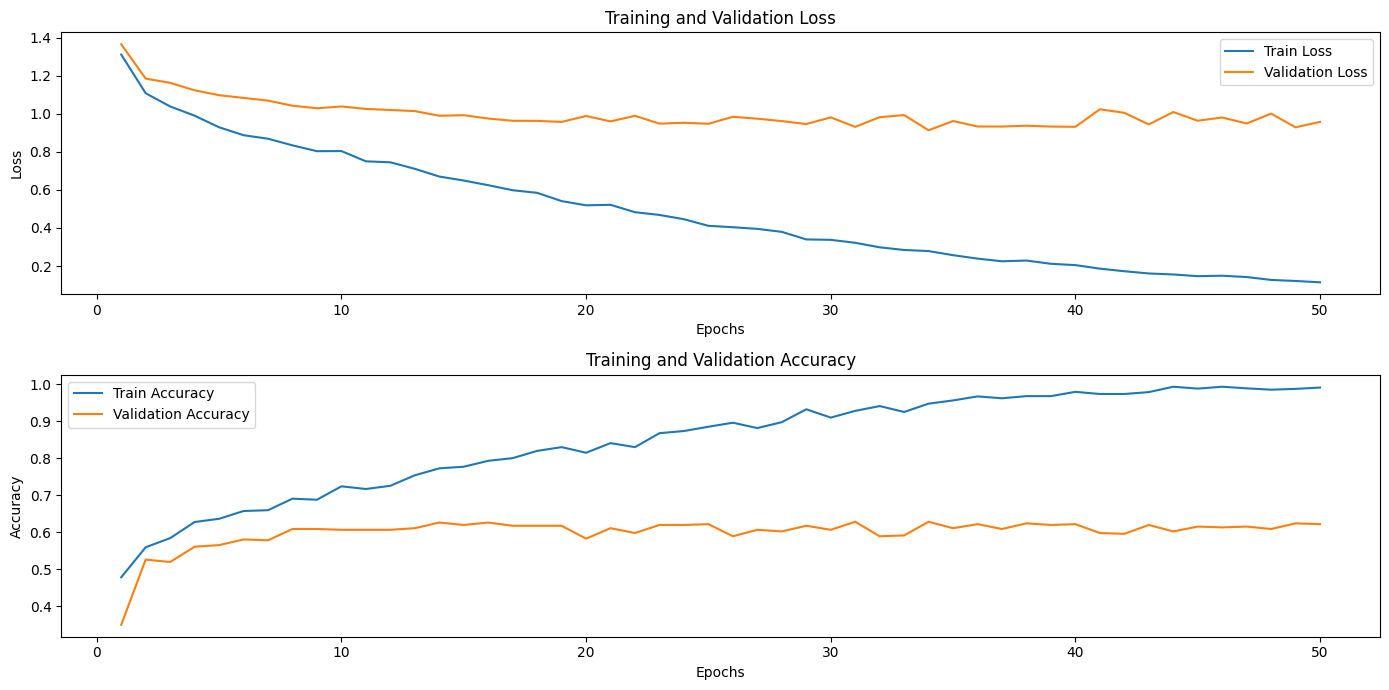

In [38]:
use_cuda = True
combined_model2 = CNNetResidual2(6)
Model1 = trainmodelnotsave(combined_model2, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=50)

In [ ]:
use_cuda = True
combined_model = CNNetResidual2(6)
Model1 = trainmodelnotsave(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=50)

Training Begin...

Epoch 1: Train Acc: 0.47, Train Loss: 1.3623 | Val Acc: 0.45, Val Loss: 1.4212
Epoch 2: Train Acc: 0.52, Train Loss: 1.1487 | Val Acc: 0.50, Val Loss: 1.2429
Epoch 3: Train Acc: 0.58, Train Loss: 1.0630 | Val Acc: 0.52, Val Loss: 1.1932
Epoch 4: Train Acc: 0.61, Train Loss: 1.0262 | Val Acc: 0.56, Val Loss: 1.1538
Epoch 5: Train Acc: 0.62, Train Loss: 0.9626 | Val Acc: 0.58, Val Loss: 1.1178
Epoch 6: Train Acc: 0.65, Train Loss: 0.9378 | Val Acc: 0.57, Val Loss: 1.1042
Epoch 7: Train Acc: 0.66, Train Loss: 0.9087 | Val Acc: 0.60, Val Loss: 1.0760
Epoch 8: Train Acc: 0.67, Train Loss: 0.8668 | Val Acc: 0.61, Val Loss: 1.0610
Epoch 9: Train Acc: 0.69, Train Loss: 0.8362 | Val Acc: 0.59, Val Loss: 1.0509
Epoch 10: Train Acc: 0.69, Train Loss: 0.8190 | Val Acc: 0.60, Val Loss: 1.0338
Epoch 11: Train Acc: 0.70, Train Loss: 0.7823 | Val Acc: 0.61, Val Loss: 1.0270
Epoch 12: Train Acc: 0.71, Train Loss: 0.7822 | Val Acc: 0.61, Val Loss: 1.0124
Epoch 13: Train Acc: 0.71, Tra